# Download and install


In [121]:
%%capture out
## Warning: For windows environment
## Comment the magic command %%capture out at the top of this to 
## visualize the installation process.
## Downloading the dataset
!wget http://205.174.165.80/CICDataset/NSL-KDD/Dataset/NSL-KDD.zip -nc
!mkdir data
!mkdir results
!tar -xf NSL-KDD.zip -C data

## Installing dependencies
!pip install lime --quiet
!pip install shap --quiet

# Imports and paths

In [122]:
# Importing required libraries
import numpy as np
import pandas as pd
from os import path
import os

#Suppress all warnings
import warnings
warnings.filterwarnings("ignore")

# Base path for the dataset
base_path=""
outputs_path= os.path.join(base_path, "results")
data_path = os.path.join(base_path, "data")


# Dataset description

The NSL-KDD dataset is a widely used benchmarking dataset in the network intrusion detection domain. To maintain the simplicity of the tutorial a more refined and established dataset would be more suitbale in our opinion. 

The main objective in this tutorial is three folds:
1. Giving the fundamental understanding of creating a script for the use of post-hoc XAI methods in network intrusion detection domain.
2. Providing a comprehensible understanding on the information that can be obtained from post-hoc XAI methods.
3. Demonstrate the power of XAI when it comes to distinguishing adversarial influence on the models.

The process is as follows:
1. We first clean the dataset encode the categorical features.
2. We then train a neural network model using tensorflow that will identify if a connection is a normal one or an attack. (binary classification).
3. Then we apply SHAP to generate the model behaviors globally and locally.
4. With LIME we show the local explanations.
5. Then we generate adversarial examples from the testing dataset.
6. Take the same explanations for the evasion dataset.
7. Discuss the observations.

Details of the features are as follows:
1. duration : The length of the connection time.
2. protocol_type : The protocol type used.
3. service : The target network service used.
4. flag : Connection status (Normal or Error).
5. src_bytes : Number of data bytes transferred from source to destination in a single connection.
6. dst_bytes : Number of data bytes transferred from destination to source in a single connection.
7. land : This variable takes the value 1 or 0 if the source IP, destination IP addresses, and port numbers are equal.
8. wrong_fragment : Total number of wrong parts in this link.
9. urgent : Number of urgent packages in this link. Emergency packets are packets with the emergency bit enabled.
10. hot : The number of "hot" indicators in the content, for example: entering the content directory, creating and executing programs.
11. num_failed_logins : The number of failed login attempts.
12. logged_in : Login status : 1 when successful, 0 when not.
13. num_compromised : The number of "Compromised/Compromised" conditions.
14. root_shell : 1 from root shell, 0 otherwise.
15. su_attempted : 1 if the "su root" command was attempted, 0 otherwise.
16. num_root : Number of "root" accesses, or the number of operations performed as root on the connection.
17. num_file_creations : The number of file creations on the link.
18. num_shells : The number of shell prompts.
19. num_access_files : Number of operations on access control files.
20. num_outbound_cmds : Number of outbound commands in ftp session.
21. is_host_login : Login to hot list ie 1 if admin or root, 0 otherwise.
22. is_guest_login : 1 if guest login, 0 otherwise.
23. count : Number of connections to the same destination host as the current connection in the last two seconds
24. srv_count : Number of connections (port number) to the same service as the current connection in the last two seconds.
25. serror_rate : Percentage of connections that enable s0,s1,s2 or s3 flag(4) among connections collected in Count(23).
26. srv_serror_rate : Percentage of connections that enable s0, s1, s2 or s3 flag(4) among connections collected in srv_coun(24).
27. error_rate : Percentage of connections that have REJ flag(4) enabled among connections collected in Count(23).
28. srv_rerror_rate : Percentage of connections that have REJ flag(4) enabled among connections collected in srv_count(24).
29. same_srv_rate : Percentage of connections that are the same service among connections collected in Count(23).
30. diff_srv_rate : Percentage of connections with different services among connections collected in Count(23).
31. srv_diff_host_rate : Percentage of connections to different target machines among connections collected in srv_count (24).
32. dst_host_count : The number of connections with the same destination host IP address.
33. dst_host_srv_count : The number of connections with the same port number.
34. dst_host_same_srv_rate : Percentage of connections that are the same service among connections collected in dst_host_count (32).
35. dst_host_diff_srv_rate : Percentage of connections to different services among connections collected in dst_host_count (32).
36. dst_host_same_src_port_rate : Percentage of connections to the same source port among connections collected in dst_host_srv_count (33)
37. dst_host_srv_diff_host_rate : Percentage of connections to different target machines among connections collected in dst_host_srv_count(33).
38. dst_host_serror_rate : The percentage of connections that have enabled the s0, s1, s2 or s3 flag(4) among connections collected in dst_host_count (32).
39. dst_host_srv_serror_rate : Percentage of connections that enable s0, s1, s2 or s3 flag(4) among connections collected in dst_host_srv_count (33).
40. dst_host_rerror_rate : Percentage of connections that have REJ flag(4) enabled among connections collected in dst_host_count (32).
41. dst_host_srv_rerror_rate : Percentage of connections that have REJ flag(4) enabled among connections collected in dst_host_srv_count(33)
42. attack: Types of attacks.
43. level : Difficulty level.


# Preparing the datast

`NSLKDD_data` class is responsible for all the cleaning functions of the NSL-KDD dataset.

In the `preprocess_data` method we binarize the labels. Then we discard the `difficulty` column and `num_outbound_cmds` column. The `difficulty` is a measure of how different models find the connections to be detection. It is irrelevant to our annalysis. `num_outbound_cmds` had a single value so no contribution is given by it. 

`su_attempted` feature is a binary feature but the presence of value 2 on top of 0 and 1 makes it erroneous. So we replace 2 with value 0.

Then we encode the categorical columns in one hot encoding. Also the continous numerical columns are scaled using StandardScaler.

In [123]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

class NSLKDD_data():
  """ Handle preprocessing and ouput a usable dataframe. Drops unnecessary columns,
  seperate continuous and categorical columns.

  Parameters
  ----------
  data_path (str) : Base path for the dataset folder

  Returns
  ----------
  None
  """
  def __init__(self, data_path):
    
    # NSL-KDD feature list
    self.FEATURES = ["duration","protocol_type","service","flag","src_bytes","dst_bytes",
              "land","wrong_fragment","urgent","hot","num_failed_logins","logged_in",
              "num_compromised","root_shell","su_attempted","num_root","num_file_creations",
              "num_shells","num_access_files","num_outbound_cmds","is_host_login",
              "is_guest_login","count","srv_count","serror_rate","srv_serror_rate",
              "rerror_rate","srv_rerror_rate","same_srv_rate","diff_srv_rate",
              "srv_diff_host_rate","dst_host_count","dst_host_srv_count","dst_host_same_srv_rate",
              "dst_host_diff_srv_rate","dst_host_same_src_port_rate",
              "dst_host_srv_diff_host_rate","dst_host_serror_rate","dst_host_srv_serror_rate",
              "dst_host_rerror_rate","dst_host_srv_rerror_rate","label","difficulty"]

    # (TBD) Multiclass classification labels
    self.MULTICLASS_ATTACK={ 'normal': ['normal'],
        'probe': ['ipsweep', 'nmap', 'portsweep','satan', 'saint', 'mscan'],
        'dos': ['back', 'land', 'neptune', 'pod', 'smurf','teardrop', 'apache2',
                'udpstorm', 'processtable','mailbomb'],
        'u2r': ['buffer_overflow', 'loadmodule', 'perl', 'rootkit','xterm', 'ps', 'sqlattack'],
        'r2l': ['ftp_write', 'guess_passwd', 'imap', 'multihop','phf', 'spy',
                'warezclient', 'warezmaster','snmpgetattack', 'named', 'xlock', 
                'xsnoop','sendmail', 'httptunnel', 'worm', 'snmpguess']}
    
    # path to the dataset
    self.DATA_PATH_TRAIN = os.path.join(data_path, "KDDTrain+.txt")
    self.DATA_PATH_TEST = os.path.join(data_path, "KDDTest+.txt")
    
    # Define the labels for binary classification
    self.NORMAL = 0
    self.ATTACK = 1
    
    self.full_X, self.full_y = self.read_nslkdd_dataset(self.DATA_PATH_TRAIN
                                                      , self.DATA_PATH_TEST
                                                      , self.FEATURES)
    self.encoder = OneHotEncoder(sparse=False)
  
  def _categorize_cols(self, df):
    # Binary numeric column names 
    #['land','logged_in','root_shell', 'su_attempted','is_host_login','is_guest_login']
    self.BINARY_COLS = self.get_binary_cols(df)

    # Non-binary string categorical column names
    # ['protocol_type','service','flag']
    self.CAT_COLS_STR_NB = self.get_categorical_str_cols(df)

    # Total Categorical columns
    #['protocol_type','service','flag','land','logged_in','root_shell','su_attempted',
    # 'is_host_login','is_guest_login']
    self.CAT_COLS = self.BINARY_COLS + self.CAT_COLS_STR_NB
    # Total Quantitative columns
    self.QUANT_COLS = [x for x in df.columns.to_list() if x not in self.CAT_COLS]
  
  def get_binary_cols(self, df):
    nunique_sr = df.select_dtypes(exclude=['object']).nunique() # numeric unique number of values
    return nunique_sr[nunique_sr <= 2].index.to_list()

  def get_categorical_str_cols(self, df):
    numeric_df = df.apply(pd.to_numeric, errors='ignore')
    # df.applymap(lambda x: isinstance(x, str)).all(0) 
    # (df.applymap(type) == str).all(0) # check col type for doing this
    return df.select_dtypes(include=['object']).columns.to_list()

  # Read both train and test data files ad concatenate into one dataframe
  def read_nslkdd_dataset(self, train_path, test_path, names):
    train_data = pd.concat([pd.read_csv(train_path, names=names), 
                            pd.read_csv(test_path, names=names)])
    labels = train_data['label']
    train_data.pop('label')
    return train_data, labels

  def _df_transformations(self, df):
    # Get one hot encoded categorical columns and normalize the numerical columns
    transformer = ColumnTransformer([('encoder', OneHotEncoder(),
                                      nsl_data.CAT_COLS_STR_NB), 
                                      ('normalizer', StandardScaler()
                                      , self.QUANT_COLS)],
                                      remainder='passthrough',
                                      verbose_feature_names_out=False)
    transformed_df = pd.DataFrame(transformer.fit_transform(df),
                                  columns=transformer.get_feature_names_out())
    return transformed_df

  def preprocess_data(self, classification='binary', split_ratio=0.25):
    """
    Handle preprocessing and ouput a usable dataframe. Drops unnecessary columns,
    seperate continuous and categorical columns.

    Parameters
    ----------
        classification : str
            Type of inference whether it is 'binary' or 'multi-class'
        split_ratio : float
            Train, test data split ratio
    Returns
    -------
        X_train (df): Training samples
        y_train (df): Training labels
        X_test (df):  Testing samples
        y_test (df): Testing labels
    """
    if self.full_X is not None:
      df = self.full_X
    else:
      print("Dataset is not read properly")

    # adjusting the label columns
    # (TBD) "else" for multiclass classification
    if classification == 'binary':
      bin_label = pd.DataFrame(self.full_y.map(
          lambda x:self.NORMAL if x=='normal' else self.ATTACK))
      
    #drop unnecessary features (outbound has only one value - recheck)
    df.drop(['difficulty'],axis=1,inplace=True)
    df.drop(['num_outbound_cmds'],axis=1,inplace=True)
      
    # correcting su_attempted
    df['su_attempted'].replace(to_replace=2, value=0, inplace=True)
    
    # Save column details
    self._categorize_cols(df) # categorizing the 40 columns

    # Standardize the continous features
    # Encode the categorical features
    df = self._df_transformations(df)

    # (TBD) Encode the labels for multiclass classification

    # Putting to canonical terms
    X_train, X_test, y_train, y_test = train_test_split(df, bin_label, test_size=split_ratio, random_state=40)
    return X_train, X_test, y_train, y_test

nsl_data = NSLKDD_data(data_path)
X_train, X_test, y_train, y_test = nsl_data.preprocess_data()


# Training the models

## Neural Network

In [124]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

from sklearn.metrics import accuracy_score # for calculating accuracy of model
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import classification_report # for generating a classification report of model
# for displaying confusion matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# For creating evasion attacks
from art.attacks.evasion import FastGradientMethod
from art.estimators.classification import KerasClassifier


In [125]:
labels = ['Normal', 'Attack']
features = list(X_train.columns)

# Define the Keras model
model = Sequential()
model.add(Dense(12, input_shape=(121,), activation='relu'))
model.add(Dropout(.2))
model.add(Dense(7, activation='relu'))
model.add(Dropout(.2))
model.add(Dense(2, activation='sigmoid'))

# Compile the Keras model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


model = KerasClassifier(model=model, use_logits=False)

# Fit the Keras model on the dataset
# history = model.fit(X_train, y_train, epochs=2, batch_size=10)
history = model.fit(X_train, y_train, nb_epochs=2, batch_size=64)


Train on 111387 samples
Epoch 1/2
111387/111387 [==============================] - 3s 29us/sample - loss: 0.3183 - accuracy: 0.9194
Epoch 2/2
111387/111387 [==============================] - 3s 25us/sample - loss: 0.1440 - accuracy: 0.9648


NN-Classifier Binary Set-Accuracy is  97.60032318879612
NN-Classifier MCC is  0.9520468798406061
              precision    recall  f1-score   support

      Normal       0.98      0.97      0.98     19204
      Attack       0.97      0.98      0.98     17926

    accuracy                           0.98     37130
   macro avg       0.98      0.98      0.98     37130
weighted avg       0.98      0.98      0.98     37130



Text(0.5, 1.0, 'Confusion Matrix')

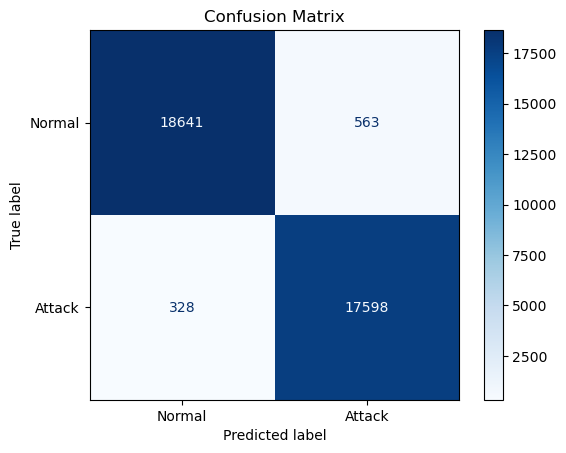

In [126]:
y_pred = model.predict(X_test) # predicting on testing dataset
# y_pred = np.where(y_pred>0.5, 1, 0)
y_pred = np.argmax(y_pred, axis=1)[..., None] # Introduce a singleton axis to 
ac = accuracy_score(y_test, y_pred)*100 # calculating accuracy
print("NN-Classifier Binary Set-Accuracy is ", ac)
mcc = matthews_corrcoef(y_test, y_pred) # Calculating Mathews Correlation Coefficient
print("NN-Classifier MCC is ", mcc)

# classification report
print(classification_report(y_test, y_pred, target_names=labels))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap=plt.cm.Blues)
disp.ax_.set_title("Confusion Matrix")

## SHAP

### Global Explanations (SHAP)

In [127]:
%%capture out
import shap
X_test_summary = shap.kmeans(X_test, 10)
explainer = shap.KernelExplainer(model.predict, X_test_summary)
shap_values = explainer.shap_values(X_test[:100], nsamples=100)

#### Beehive plot

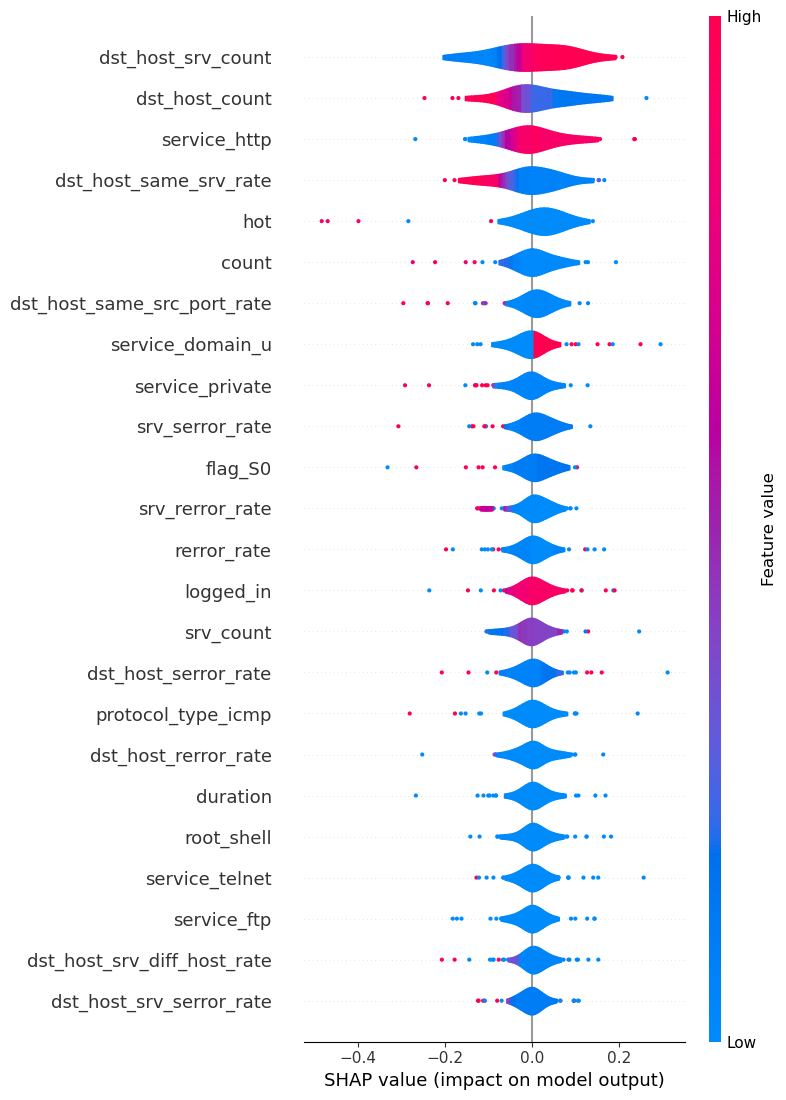

In [128]:
shap.summary_plot(shap_values[0], X_test[:100], feature_names=features, max_display=24, 
                     color_bar_label='Feature value', plot_type="violin")

# shap.summary_plot(shap_values, X_test[:100], feature_names=features, max_display=24, 
#                     class_names=['Normal'], color_bar_label='Feature value for all')

#### Dependency plot

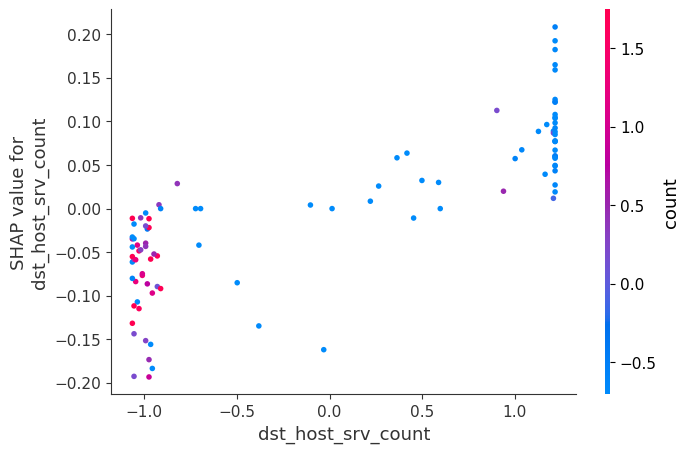

In [129]:
# Use the 'rank(i)' notation to get the plot of the i rank from the feature importance.
# Use the feature name as in the columns of the X_train df to see a specific feature
shap.dependence_plot("rank(0)", shap_values[0], X_test[:100])

### Local Explanations (SHAP)

In [131]:
shap.initjs()
#By changing this number you can see the local explanations for various input samples
i=201
shap_values = explainer.shap_values(X_test.values[i])
print("Actual target:", "Normal" if y_test.values[i]==1 else "Attack")
print("Base Value: ", explainer.expected_value[0])
shap.force_plot(explainer.expected_value[0], shap_values[0], feature_names = features
                # ,matplotlib=True
                )

Actual target: Normal
Base Value:  0.5170843668356276


## LIME

### Local explanations (LIME)

In [132]:
import lime
import random

from lime import lime_tabular
from matplotlib import pyplot as plt

#
idx = 201
print("Local interpretation of sample " + str(idx + 1))
print("Prediction : ", model.predict(X_test.values[idx].reshape(1,-1)))
print("Actual :     ", y_test.values[idx])

classes=labels
predict_fn_nn= lambda x: model.predict(x)
lime_explainer = lime_tabular.LimeTabularExplainer(X_test.values, mode="classification", feature_names=features, feature_selection= 'auto',
                                                kernel_width=None, discretize_continuous=True, class_names=classes)
lime_explanation = lime_explainer.explain_instance(X_test.values[idx], predict_fn_nn, num_features=10, top_labels=3)

plt.tight_layout()
lime_explanation.show_in_notebook()

Local interpretation of sample 202
Prediction :  [[0.08886917 0.91528875]]
Actual :      [1]


<Figure size 640x480 with 0 Axes>

# Adversarial attack (Evasion)

## SHAP

### Global explanations (SHAP)

#### Behive plot

#### Dependency plot

### Local explanations (SHAP) 

## LIME

### Local explanations (LIME)